In [1]:
from torchvision.models import EfficientNet_V2_M_Weights, efficientnet_v2_m
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
testImgPath = "C:/Users/josem/Documents/schoolWork/MQP/algonauts2023_transformers#2Leader/algonauts_2023_challenge_data/subj01/training_split/training_images/train-0164_nsd-01362.png"
img = Image.open(testImgPath)

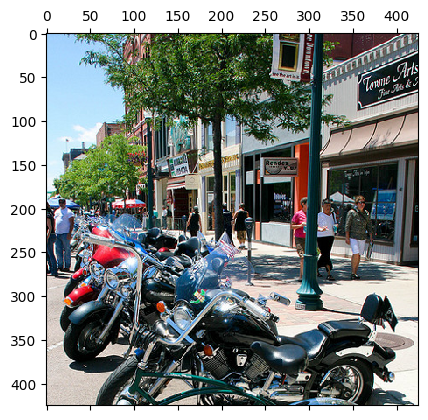

In [3]:
plt.matshow(img)

In [3]:
tsfms = transforms.Compose([
    transforms.Resize(425),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



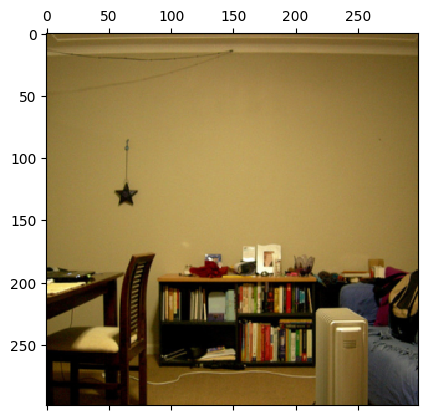

In [12]:
plt.matshow(tsfms(img).permute(1,2,0))

In [4]:
# inception = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [25]:
list(model.features.children())[-1]._modules.items()


odict_items([('0', Conv2d(512, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)), ('1', BatchNorm2d(1280, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)), ('2', SiLU(inplace=True))])

In [32]:
# for name, module in model._modules.items():
#     print(f"name {name} : Modile {module}")

list(model.features[-1].children())[0]._get_name()

'Conv2d'

In [18]:
class EfficientNetMGradCam(torch.nn.Module):
    def __init__(self):
        super(EfficientNetMGradCam, self).__init__()
        self.efficientNet = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
        self.features = self.efficientNet.features
        self.layersBeforeGradCamTarget = self.features[:-1]
        self.targetLayer = self.features[-1]
        self.avgPool = self.efficientNet.avgpool
        self.classifier = self.efficientNet.classifier
        self.gradients = None

    def forward(self, img):
        # layersInTarget = list(self.targetLayer.children()) #Conv2d, BatchNorm2d, SiLU

        features = self.features(img)
        # for layer in layersInTarget:
        #     features = layer(features)
        #     if layer._get_name() == "Conv2d":
        #         hook = features.register_hook(self.activations_hook)

        features = self.avgPool(features)
        features = torch.flatten(features, 1)

        output = self.classifier(features)
        return output
        


    def activations_hook(self, grad):
        self.gradients = grad

    def get_activation_gradient(self):
        return self.gradients

    def get_activations(self, img):
        #todo fix this
        return self.vggConvFeatures(img)

In [19]:
model = EfficientNetMGradCam()

In [20]:
tsfms(img)[None, :, :, :].shape


torch.Size([1, 3, 425, 425])

In [5]:
output = model(tsfms(img)[None, :, :, :])

In [8]:
output.shape

torch.Size([1, 1000])

In [6]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [9]:
print("tes")

tes


In [10]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

motor scooter 0.4278474748134613
moped 0.11207503825426102
crash helmet 0.0319894403219223
snowmobile 0.00432254234328866
disk brake 0.003994081635028124
